# Fitbit Data Exploration: Making a prediction for the two weeks of missing data

By: Norrick McGee and Eric Escalante  
January 19, 2019  

In this Jupyter Notebook, we will use the Time Series Methology and fitbit data collected from 04/26/2018 to 12/06/2018 to predict two weeks worth of missing data; we will add our pridicted data in a separate csv file.

## Imports
**Import the necessary packages and their use cases for this project:**
> **pandas:** data frames and data manipulation  
> **numpy:** summary statistics  
> **matplotlib:** used for visualizations  
> **seasborn:** fancy visualizations  
> **datetime:** turn the dates into datetime objects / get day of week  
> **warning:** used to ignore python warnings

In [259]:
from acquire import acquire_fitbit

import numpy as np
import pandas as pd

import os
from datetime import datetime
import itertools
 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Table of contents
1. [Project Planning](#project-planning)
1. [Acquisition](#acquisition)
1. [Preparation](#preparation)
1. [Exploration](#exploration)
1. [Modeling](#modeling)

## Project Planning <a name="project-planning"></a>

### Goals  
> Goals for the Project are:  
1. We will predict using different Time Series Methodologies the missing two weeks of Fitbit data
2. We will show the reasoning behind our preditions with visualizations and statistical findings
3. Finally we will create a viewable csv file with those pridictions so that you could see the endire dataset

### Deliverables

**_TODO:_**
> Summarization of the data:

### Data Dictionary & Domain Knowledge

So we have sixteen columns in our dataset. Let us understand what each one is.

> **activity_calories:** amount of calories burned throughout the day   
> **calories:** amount of calories consumed throughout the day  
> **carbs:** amount of carbs consumed throughout the day  
> **distance:** distance traveled  
> **fat:** amount of fat consumed throughout the day  
> **fiber:** amount of fiber comsumed throughout the day  
> **floors:** floors climbed  
> **mins_active_high:** minutes of high activity in the day   
> **mins_active_light:** minutes of light activity in the day  
> **mins_active_med:** minutes of moderate activity in the day  
> **mins_sedentary:** minutes the fit bit assums you are sitting down  
> **protien:** amount of protein consumed throughout the day  
> **sodium:** amount of sodium consumed throughout the day  
> **steps:** total amount of steps taken in a day  
> **total_calories:** total calories consumed throughout the day  
> **water:** metric desplays tracked water intake or set a consumption

### Hypotheses

**_TODO:_**  
> Hypotheses:

### Thoughts & Questions

**_TODO:_**
> Thoughts:  
> Questions:

## Prepare the Environment

## Preparation <a name="preparation"></a>

In [202]:
df = pd.concat(acquire_fitbit())
df = df.convert_objects(convert_numeric=True, convert_dates=True)
df.index = pd.to_datetime(df.index, utc=True)

In [206]:
def add_date_parts(df):
    '''
    Function to add columns based on date: year, quarter, month, day of month, day of week
    '''
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['weekday'] = df.index.day_name()
    
    return df

def nulls_by_col(df):
    '''
    Funciton used to find missing information in each column
    '''
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    pct_missing = num_missing/rows
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'pct_rows_missing': pct_missing})
    
    return cols_missing

def nulls_by_row(df):
    '''
    Function used to find missing information in each row
    '''
    num_cols_missing = df.isnull().sum(axis=1)
    pct_cols_missing = df.isnull().sum(axis=1)/df.shape[1]*100
    rows_missing = pd.DataFrame({'num_cols_missing': num_cols_missing, 'pct_cols_missing': pct_cols_missing})\
                     .reset_index().groupby(['num_cols_missing','pct_cols_missing']).count()\
                     .rename(index=str, columns={'index': 'num_rows'}).reset_index()
    
    return rows_missing

def df_summary(df):
    '''
    Funciton summarizes our created data frame with information on: shape, type & null info, desribe function from pandas library, null values by column, null values by row, and value counts
    '''
    print('--- Shape: {}'.format(df.shape))
    print('--- Info')
    df.info()
    print('--- Descriptions')
    print(df.describe(include='all'))
    print('--- Nulls By Column')
    print(nulls_by_col(df))
    print('--- Nulls By Row')
    print(nulls_by_row(df))

In [204]:
df = add_date_parts(df)

In [205]:
df_summary(df)

--- Shape: (711, 21)
--- Info
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 711 entries, 2018-04-26 to 2018-12-28
Data columns (total 21 columns):
activity_calories    50 non-null float64
calories             474 non-null float64
carbs                239 non-null object
distance             225 non-null float64
fat                  239 non-null object
fiber                239 non-null object
floors               225 non-null float64
mins_active_high     225 non-null float64
mins_active_light    225 non-null float64
mins_active_med      225 non-null float64
mins_sedentary       188 non-null float64
protien              239 non-null object
sodium               239 non-null object
steps                20 non-null float64
total_calories       1 non-null float64
water                239 non-null object
year                 711 non-null int64
quarter              711 non-null int64
month                711 non-null int64
day                  711 non-null int64
weekday              711

### Handle Missing Values


>- We do want to look where are current numbers land to see how we want to structure our null values
>- Option could be just to add a zero there; reasoning could because the person forgot to log his info
>- Could use the average because if these guys are so busy that they do not have time for side conversations they may just eat/do the same thing each day  
>- There are non-type or int + str types that we need to work on what to do in this case

In [149]:
for col in df.select_dtypes('number'):
    print(f'\n- {col} -')
    print(df[col].value_counts(bins=4))


- activity_calories -
(749.25, 999.0]    19
(-1.0, 249.75]     17
(499.5, 749.25]     7
(249.75, 499.5]     7
Name: activity_calories, dtype: int64

- calories -
(-0.808, 201.75]    470
(605.25, 807.0]       2
(403.5, 605.25]       2
(201.75, 403.5]       0
Name: calories, dtype: int64

- distance -
(3.0, 6.0]                      88
(-0.013000000000000001, 3.0]    83
(6.0, 9.0]                      48
(9.0, 12.0]                      6
Name: distance, dtype: int64

- floors -
(-0.196, 48.75]    216
(97.5, 146.25]       4
(146.25, 195.0]      3
(48.75, 97.5]        2
Name: floors, dtype: int64

- mins_active_high -
(-0.155, 38.5]    142
(38.5, 77.0]       43
(77.0, 115.5]      36
(115.5, 154.0]      4
Name: mins_active_high, dtype: int64

- mins_active_light -
(174.5, 261.75]    121
(87.25, 174.5]      53
(261.75, 349.0]     27
(-0.35, 87.25]      24
Name: mins_active_light, dtype: int64

- mins_active_med -
(-0.079, 19.5]    161
(19.5, 39.0]       45
(39.0, 58.5]       15
(58.5, 78.0

### Handle Duplicates

**_TODO:_**
> Do we have duplicated data

### Handle Outliers

**_TODO:_**
> Personally do not want to remove outliers here

### Re-Check Missing Values & Summary

In [109]:
df_summary(df)

--- Shape: (711, 16)
--- Info
<class 'pandas.core.frame.DataFrame'>
Index: 711 entries, 2018-04-26 to 20181228
Data columns (total 16 columns):
activity_calories    50 non-null float64
calories             474 non-null float64
carbs                239 non-null object
distance             225 non-null float64
fat                  239 non-null object
fiber                239 non-null object
floors               225 non-null float64
mins_active_high     225 non-null float64
mins_active_light    225 non-null float64
mins_active_med      225 non-null float64
mins_sedentary       188 non-null float64
protien              239 non-null object
sodium               239 non-null object
steps                20 non-null float64
total_calories       1 non-null float64
water                239 non-null object
dtypes: float64(10), object(6)
memory usage: 114.4+ KB
--- Descriptions
        activity_calories    calories carbs    distance  fat fiber  \
count           50.000000  474.000000   239  225.000

## Exploration  <a name="exploration"></a>

In [323]:
def summary_stat(df, col_name):
    '''
    Function to provide median, min, and max of data in column -> returns a new small dataframe with the info
    '''
    df = pd.DataFrame({'Mean ' : str(round(np.mean(df[col_name]),2)),
         'Median' : str(np.median(df[col_name])),
         'Min' : str(np.min(df[col_name])),
         'Max' : str(np.max(df[col_name]))}, index=[0])
    return df

def bin_feature(df, col, newcol, bin_cuts=[]):
    '''
    Function we will use to bin different columns during our exploration -> returns the dataframe with the column binned 
    '''
    labs = list(range(len(bin_cuts)))[1:]
    df[newcol] = pd.cut(df[col], bin_cuts, labels=labs, include_lowest=False)
    return df


def createheatmap(df):
    '''
    Function we will use to create heatmaps with pretty specific parameters that keep these heatmaps uniform
    '''
    sns.set(style = "white")
    corrd = df.corr()
    mask = np.zeros_like(corrd, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(15, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corrd, mask=mask, cmap=cmap, square=True, 
                xticklabels=True, yticklabels=True, 
                linewidths=.5, ax=ax)

Text(0.5, 0, 'Month of the Year')

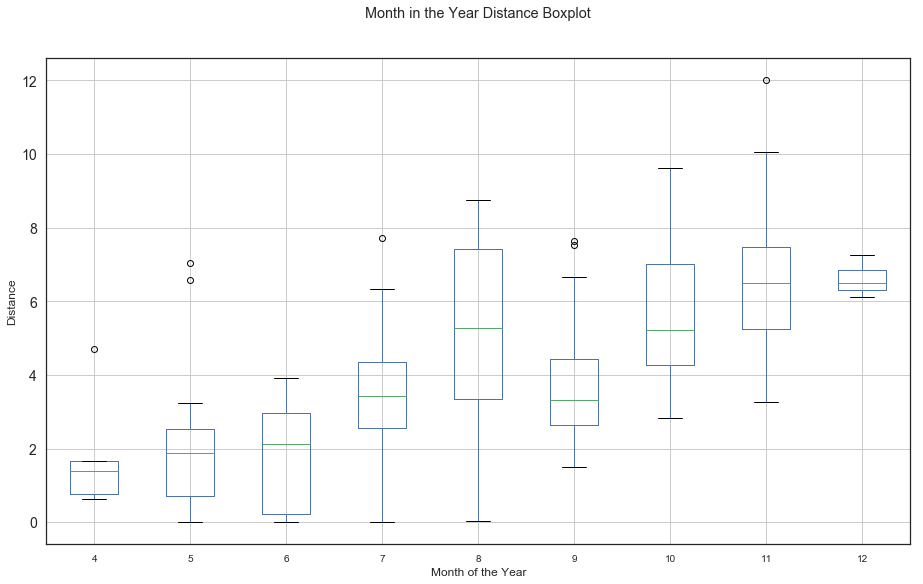

In [322]:
df.boxplot(column = 'distance', by = 'month', figsize=(15,9))

plt.xticks(fontsize=10)  
plt.yticks(fontsize=14)

plt.title('')
plt.suptitle('Month in the Year Distance Boxplot')
plt.ylabel('Distance')
plt.xlabel('Month of the Year')

**_TODO:_**
> Need to write a detailed breakdown of what the data shows us here

Text(0, 0.5, 'Distance')

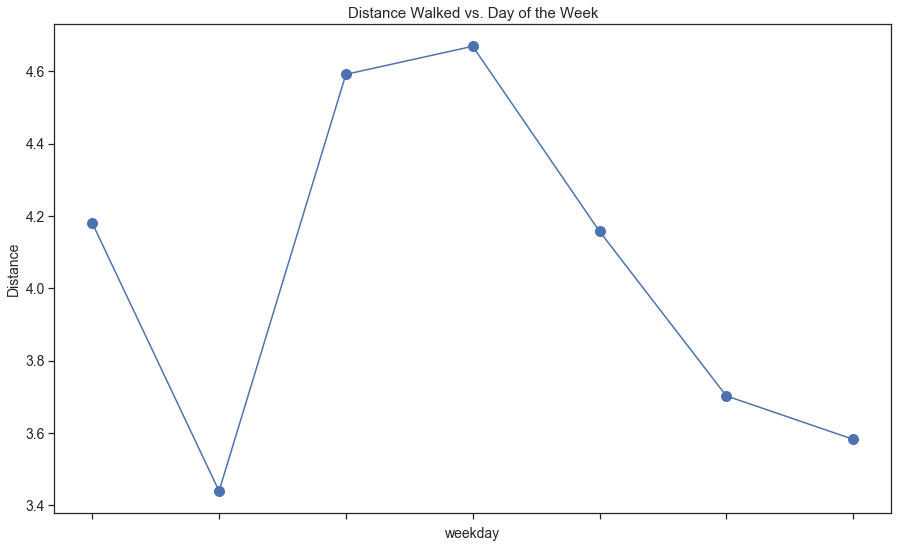

In [319]:
fig = plt.figure(figsize = (15,9))

ax = fig.add_subplot(111)
DOWdf = df.groupby(by='weekday').mean()
meanDOW = DOWdf['distance']
meanDOW.plot(linestyle='-', marker='o', markersize=10)

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()

plt.xticks(fontsize=10)  
plt.yticks(fontsize=14)  

plt.title('Distance Walked vs. Day of the Week', fontsize=15)
plt.xlabel('Weekday', fontsize=14)
plt.xlabel('Day of the Week')
plt.xlabel(meanDOW.index.name, fontsize=14)
plt.ylabel('Distance', fontsize=14)

**_TODO:_**
> Need to write a detailed breakdown of what the data shows us here

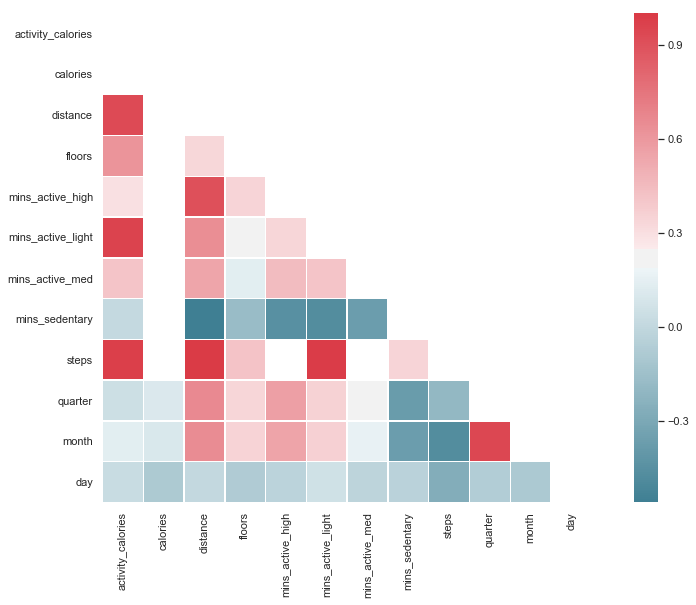

In [320]:
createheatmap(df.drop(columns=['total_calories', 'year']))

**_TODO:_**
> Need to figure out different correlations here speak to them...  
> Currently - Total year has too many missing values & year only has the one  
> Which variables are we going to start binning?  
> Which statistical models are we going to start preparing for?

### Train-Test Split

**_TODO:_**
> Going to be a little bit different here because we have multiple independent variables

### Visualizations

**_TODO:_**
> **TIME TO SHINE!**

### Statistical Tests

In [112]:
def calculate_r2(Actual_Y, Estimated_Y):
    '''
    Function that calculates R squared
    '''
    return float(1 - sum((Actual_Y-Estimated_Y)**2 ) / sum((Actual_Y-Actual_Y.mean(axis=0))**2))

def calculate_rmse(Actual_Y, Estimated_Y):
    '''
    Function that calculates Root Mean Squared Error
    '''
    return(math.sqrt(sum((Actual_Y-Estimated_Y )**2 ) / Actual_Y.shape[0]))

### Summarize Conclusions

**_TODO:_**
> Summarize our statistical findings

## Modeling <a name="modeling"></a>

### Feature Engineering & Selection

In [8]:
def new_features(df):
    '''
    Function used to create new features -> returns the original dataframe with new features added
    '''
    return df

### Train & Test Models

**_TODO:_**
> Build some models here:
1. Would like to build a few functions here so that we could do differnt ML methods
2. What is going to be our goal??

### Summarize Conclusions

**_TODO:_**
> Sumarize our training and test builds  
> Create the CSV  
> Find differnt ways to improve  